In [1]:
import sys
#change the next line to reflect where you have downloaded the source code
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools




# **First, some basic functions that query JPL services for small bodies and planets**

In [5]:
# querying a small body's orbit from JPL returns a flag (1 for sucess, 0 for failure), 
# the epoch, and the heliocentric cartesian coordinates for the best fit plus however
# many clones is specified

#example with no clones
sbody = 'K14X40T'
(flag, epoch, x,y,z,vx,vy,vz) = horizons_api.query_sb_from_jpl(des=sbody,clones=0)
if(flag):
    print("queried %s and returned at epoch %f" % (sbody,epoch))
    print("cartesian heliocentric position (au), velocity (au/year):\n %e %e %e\n %e %e %e" % (x,y,z,vx,vy,vz))

queried K14X40T and returned at epoch 2457019.500000
cartesian heliocentric position (au), velocity (au/year):
 2.060804e+01 2.446023e+01 -4.340106e-01
 -8.946951e-01 8.022772e-01 -1.542420e-01


In [10]:
# example with 5 clones, first return is best fit, followed by 5
# clones sampled from the covariance matrix
clones = 5
ypx = np.zeros(clones+1); tpy = np.zeros(clones+1); tpz = np.zeros(clones+1);
tpvx = np.zeros(clones+1); tpvy = np.zeros(clones+1); tpvz = np.zeros(clones+1);
(flag, epoch, tpx,tpy,tpz,tpvx,tpvy,tpvz) = horizons_api.query_sb_from_jpl(des=sbody,clones=clones)
if(flag):
    print("queried %s and returned at epoch %f" % (sbody,epoch))
    print("cartesian heliocentric position (au), velocity (au/year) best fit, then clones")
    
    for i in range (0,clones):
        print("%e %e %e %e %e %e" % (tpx[i],tpy[i],tpz[i],tpvx[i],tpvy[i],tpvz[i]))

queried K14X40T and returned at epoch 2457019.500000
cartesian heliocentric position (au), velocity (au/year) best fit, then clones
2.060804e+01 2.446023e+01 -4.340106e-01 -8.946951e-01 8.022772e-01 -1.542420e-01
2.060802e+01 2.446019e+01 -4.340011e-01 -8.946953e-01 8.022737e-01 -1.542414e-01
2.060798e+01 2.446015e+01 -4.340079e-01 -8.946914e-01 8.022750e-01 -1.542428e-01
2.060799e+01 2.446017e+01 -4.340122e-01 -8.946931e-01 8.022723e-01 -1.542419e-01
2.060813e+01 2.446035e+01 -4.340173e-01 -8.947002e-01 8.022803e-01 -1.542427e-01


In [9]:
# You can then query the planet properties and positions for the epoch 
# returned by the small body's orbit query (showing just Jupiter as an example)
planet = 'jupiter'
(flag, mass, radius, [plx,ply,plz],[plvx,plvy,plvz]) = horizons_api.query_horizons_planets(obj=planet,epoch=epoch)
if(flag):
    print("queried %s and returned at epoch %f" % (planet,epoch))
    print("mass (solar masses) %e and radius (au) %e" % (mass,radius))
    print("cartesian heliocentric position (au), velocity (au/year):\n %e %e %e\n %e %e %e" % (plx,ply,plz,plvx,plvy,plvz))

queried jupiter and returned at epoch 2457019.500000
mass (solar masses) 9.547919e-04 and radius (au) 4.778945e-07
cartesian heliocentric position (au), velocity (au/year):
 -3.707603e+00 3.813809e+00 6.712439e-02
 -2.011063e+00 -1.792771e+00 5.244496e-02


# **Now some tools to directly set up a rebound integration**
The calls above are integrated into these functions

In [15]:
#Set up an empty simulation, specify the small body and number of clones
sim= rebound.Simulation()
sbody = 'K14X40T'
clones = 100

#initialize the simulation with the giant planets (can include all the major planets)
flag, epoch, sim = run_reb.initialize_simulation(planets=['Jupiter','Saturn','Uranus','Neptune'],
                                                 des=sbody,clones=clones)

#print out the simulation status
sim.status()


---------------------------------
REBOUND version:     	3.19.2
REBOUND built on:    	Jan 26 2022 16:46:16
Number of particles: 	106
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.400000
---------------------------------
<rebound.particle.Particle object at 0x7f802205c440, m=1.000005976998622 x=0.0028265129703477043 y=-0.0008747739485207268 z=-0.00013692912700458392 vx=0.0014561296239436793 vy=0.0019169215984325705 vz=-3.6201226684872467e-05>
<rebound.particle.Particle object at 0x7f802205c8c0, m=0.0009547919099366768 x=-3.704778181730628 y=3.812932648185939 z=0.06698756999874098 vx=-2.0096020637558456 vy=-1.7908675015935702 vz=0.05240930332261604>
<rebound.particle.Particle object at 0x7f802205c440, m=0.0002858856700231729 x=-5.422812039394216 y=-8.337885360947089 z=0.3607936715678459 vx=1.5968424935163699 vy=-1.1166650583768263 vz=-0.044134569284601806>
<rebound.particle.Particle object at 0x7f802205c8c0, m=4.3662496132004074e-05 x=19.

In [16]:
#You could proceed from here with regular rebound scripts, but we have also included some tools
#to directly run the rebound simulations, writing outputs to a simulation archive binary file
#and using a C-based heartbeat function to remove particles based on heliocentric distance

#max time in the integration (years)
tmax = 1e6

#how often you want to save the simulation archive file
tout = 1e3
savefile = "archive.bin"

#inner boundary (au)
remove_in = 20
#outer boundary (au)
remove_out = 1000


#sun the simulation, deleting any existing simulation archive and removeing 
sim = run_reb.run_simulation(sim, tmax=tmax, tout=tout,filename=savefile,
                             deletefile=True,mindist=remove_in,maxdist=remove_out)

# **Example plots from the above integration**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
abf = np.zeros(1);ebf = np.zeros(1);incbf = np.zeros(1);
t = np.zeros(1);

a = np.zeros(shape=[1,clones]);e = np.zeros(shape=[1,clones]);inc = np.zeros(shape=[1,clones]);


sa = rebound.SimulationArchive(savefile)
r2d = 180/np.pi

print(sa.tmin)
print(sa.tmax)
for j,sim in enumerate(sa):
    p = sim.particles[sbody+"_bf"]
    com = sim.calculate_com()
    o = p.calculate_orbit(com)
    t = np.append(t, sim.t)
    abf = np.append(abf, o.a)
    ebf = np.append(ebf, o.e)
    incbf = np.append(incbf, o.inc*r2d)
    ta = np.zeros(shape=[1,clones]);te = np.zeros(shape=[1,clones]);ti = np.zeros(shape=[1,clones]);
    for i in range (0,clones):
        p = sim.particles[sbody+"_"+str(i+1)]
        o = p.calculate_orbit(com)
        ta[0,i] = o.a
        te[0,i] = o.e
        ti[0,i] = o.inc*r2d
    if(j==0):
        a = ta; e = te; inc = ti;
    else:
        a = np.append(a, ta, axis=0)
        e = np.append(e, te, axis=0)
        inc = np.append(inc, ti, axis=0)



t = np.delete(t,0)
abf= np.delete(abf,0)
ebf = np.delete(ebf,0)
incbf = np.delete(incbf,0)




0.0
1000000.0


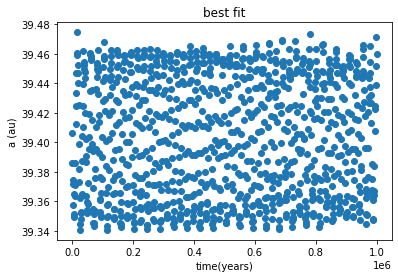

In [109]:
plt.scatter(t,abf);
plt.xlabel('time(years)');
plt.ylabel('a (au)');
plt.title('best fit');

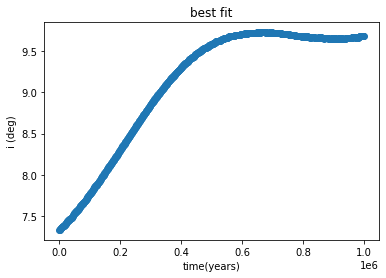

In [111]:
plt.scatter(t,incbf);
plt.xlabel('time(years)');
plt.ylabel('i (deg)');
plt.title('best fit');

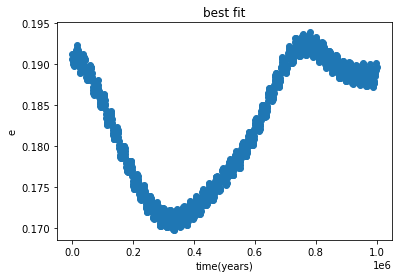

In [112]:
plt.scatter(t,ebf);
plt.xlabel('time(years)');
plt.ylabel('e');
plt.title('best fit');

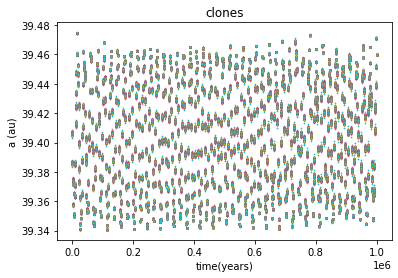

In [114]:
for i in range (0,clones):
    plt.scatter(t,a[:,i],s=0.5);
plt.xlabel('time(years)');
plt.ylabel('a (au)');
plt.title('clones');

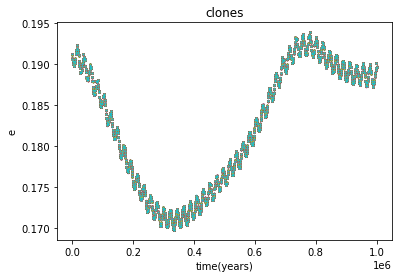

In [116]:
for i in range (0,clones):
    plt.scatter(t,e[:,i],s=0.5);
plt.xlabel('time(years)');
plt.ylabel('e');
plt.title('clones');

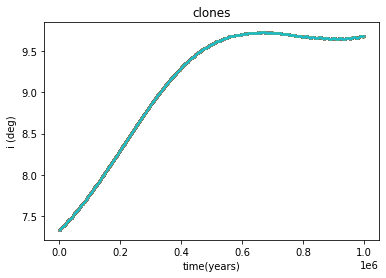

In [117]:
for i in range (0,clones):
    plt.scatter(t,inc[:,i],s=0.5);
plt.xlabel('time(years)');
plt.ylabel('i (deg)');
plt.title('clones');